## Main notebook script for PV shadow analysis.

Uses the refactored pv_analysis module with:
  - SiteConfig with inverter_utc_offset_hours=3 (confirmed fixed UTC+3)
  - Pre-smoothed shadow matrix (done once)
  - Beam/diffuse separated shadow attenuation
  - Robust timezone handling (no magic-number offsets)
  - No duplicate evaluation loops
  - Validated inverter data loading with gap reporting

In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pv_analysis_re import (
    SiteConfig,
    find_clear_days,
    load_and_smooth_shadow_matrix,
    load_extra_data_csv,
    load_inverter_data,
    pv_analysis,
    compute_metrics,
    evaluate_performance,
    print_performance_summary,
    plot_real_vs_predicted_scatter,
    calculate_api_grid,
    plot_api_map,
)

# Project modules (unchanged)
from shadow_matrix_simulation import create_shadow_matrix

try:
    from visual_utils import plot_shadow_matrix_with_sunpaths
except ImportError:
    plot_shadow_matrix_with_sunpaths = None

In [2]:
cfg = SiteConfig(
    latitude=62.979849,
    longitude=27.648656,
    tilt_deg=12.0,
    azimuth_deg=170.0,
    nominal_power_kw=3.96*0.85,  # 15% derating for system losses (cabling, inverter inefficiency, etc.)
    system_efficiency=0.95,
    local_tz="Europe/Helsinki",
    inverter_utc_offset_hours=3,  # Fronius Symo logs in fixed UTC+3
    window_size=(3, 3),
    interval="5min",
    interval_minutes=5.0,
)

# --- File Paths ---
RAD_FILE       = "data/pvdata/Kuopio Savilahti 1.4.2021 - 1.10.2021_rad.csv"
TEMP_WIND_FILE = "data/pvdata/Kuopio Savilahti 1.4.2021 - 1.10.2021_temp_wind.csv"
CLEAR_MINUTES  = "data/Clear_sky_minutes_kuopio_RH16.txt"
PV_EXCEL       = "data/pvdata/pv_21.xlsx"

LIDAR_FILE     = "output/reclassified_final_v5.laz"
SHADOW_DIR     = "results/shadow_matrix_results_SE_pro"
SHADOW_FN      = "shadow_attenuation_matrix_conecasting_SE_v7.csv"
SHADOW_CSV     = f"{SHADOW_DIR}/{SHADOW_FN}"
EXTRA_DATA_DIR = "output"

In [3]:
# %% --- 1. Find Clear Days ---
clear_days = find_clear_days(CLEAR_MINUTES, threshold=0.8)
print(clear_days.head(10))

Found 20 clear days (threshold: Q3 + 0.8 * IQR = 650 minutes)
          Date  LineCount
72  2021-07-03        914
73  2021-07-04        872
50  2021-06-09        821
52  2021-06-11        801
51  2021-06-10        796
30  2021-05-13        796
29  2021-05-12        791
45  2021-06-04        781
83  2021-07-14        759
94  2021-07-26        747


In [4]:
# %% --- 2. Load & Inspect Extra Data for First Clear Day ---
second_day = clear_days["Date"].iloc[1]
extra_data_df = load_extra_data_csv(f"{EXTRA_DATA_DIR}/extra_data_{second_day}.csv", cfg=cfg, recompute_albedo=True)
print(extra_data_df.head())

                           dni   dhi   ghi      T  wind  albedo
time                                                           
2021-07-04 00:00:00+00:00  0.0  0.00 -0.36  18.10  0.72     0.2
2021-07-04 00:05:00+00:00  0.0  0.02  0.02  18.08  0.96     0.2
2021-07-04 00:10:00+00:00  0.0  0.60  0.30  18.36  1.48     0.2
2021-07-04 00:15:00+00:00  0.0  1.68  0.48  19.12  1.82     0.2
2021-07-04 00:20:00+00:00  0.0  2.14  1.22  19.20  1.16     0.2


In [5]:
# %% --- 3. Create Shadow Matrix (ray-tracing — slow, run once) ---
# Uncomment to regenerate:
shadow_matrix_raw = create_shadow_matrix(
    lidar_file_path=LIDAR_FILE, voxel_size=2.0,
    output_dir=SHADOW_DIR, output_fn=SHADOW_FN,
)


# %% --- 4. Load & Pre-smooth Shadow Matrix (done ONCE) ---
shadow_matrix = load_and_smooth_shadow_matrix(SHADOW_CSV, window_size=cfg.window_size)
print(f"Shadow matrix shape: {shadow_matrix.shape}  (altitude x azimuth)")

Loading LiDAR data from output/reclassified_final_v5.laz...
  2,327,728 points after filtering.
  Voxel grid: 250×250×29 = 1,812,500 voxels

PV array optical center at: [5.32884235e+05 6.98350916e+06 9.36381018e+01]

  Self-occlusion skip distance: 11.0m (voxel_size=2.0m)

--- JIT warm-up (first trace) ---


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.



--- Starting Hemispherical Cone-Casting Simulation ---
  91 elevations × 360 azimuths = 32,760 directions
  12 panel points × 6 cone rays = 72 traces per direction
  Elevation   9.0° done  (3,600/32,760 = 11.0%)  [2s elapsed]
  Elevation  19.0° done  (7,200/32,760 = 22.0%)  [3s elapsed]
  Elevation  29.0° done  (10,800/32,760 = 33.0%)  [3s elapsed]
  Elevation  39.0° done  (14,400/32,760 = 44.0%)  [4s elapsed]
  Elevation  49.0° done  (18,000/32,760 = 54.9%)  [4s elapsed]
  Elevation  59.0° done  (21,600/32,760 = 65.9%)  [5s elapsed]
  Elevation  69.0° done  (25,200/32,760 = 76.9%)  [5s elapsed]
  Elevation  79.0° done  (28,800/32,760 = 87.9%)  [6s elapsed]
  Elevation  89.0° done  (32,400/32,760 = 98.9%)  [6s elapsed]
  Elevation  90.0° done  (32,760/32,760 = 100.0%)  [6s elapsed]

Saved shadow attenuation matrix to results/shadow_matrix_results_SE_pro/shadow_attenuation_matrix_conecasting_SE_v7.csv
Total execution time: 6.19s (0.1 min)
Shadow matrix shape: (91, 361)  (altitude x azi

Loading shadow matrix...
Calculating seasonal sun paths...


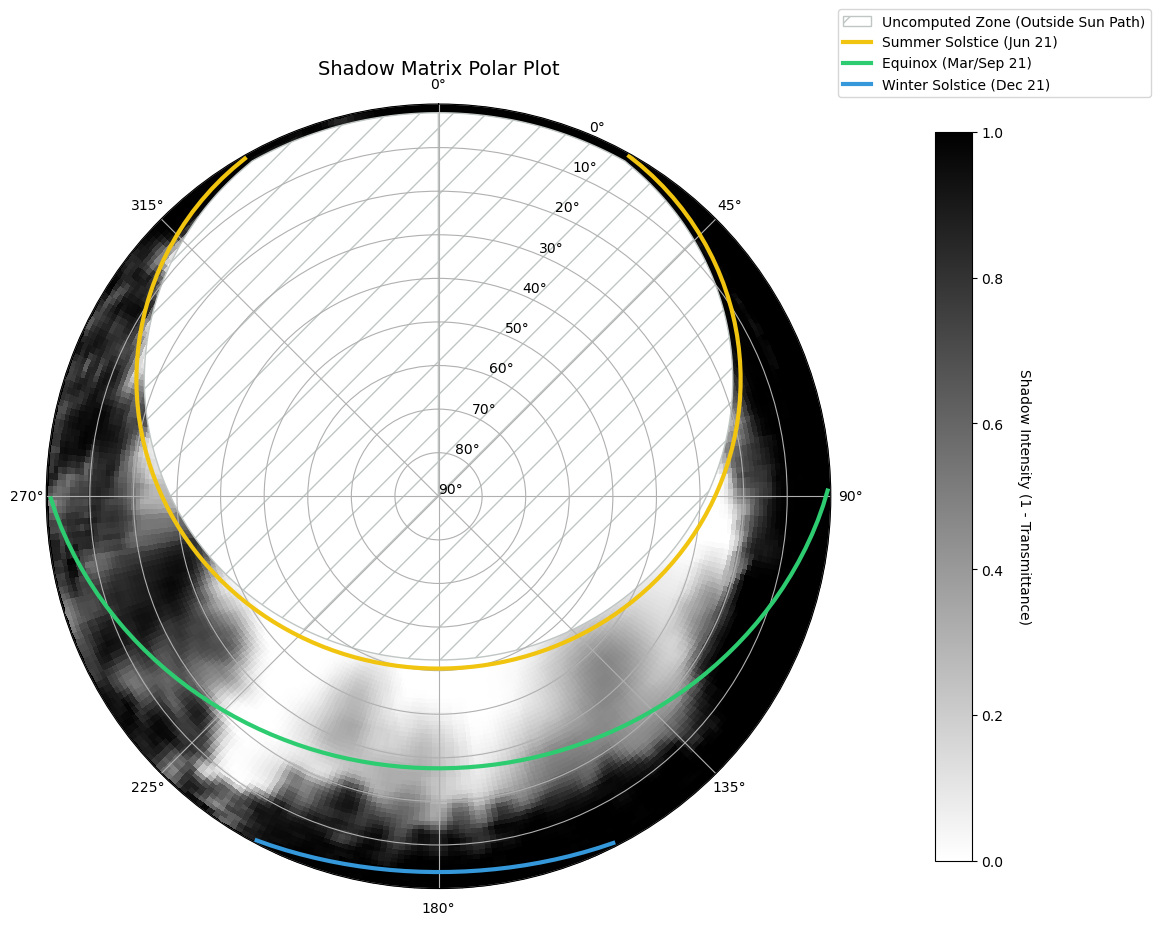

In [18]:
# %% --- 5. Visualise Shadow Matrix ---
if plot_shadow_matrix_with_sunpaths is not None:
    plot_shadow_matrix_with_sunpaths(SHADOW_CSV, fill_missing=True)

In [12]:
# %% --- 6. Load Inverter Data ---
pv_df = load_inverter_data(PV_EXCEL, expected_interval_min=cfg.interval_minutes)
print(f"Range: {pv_df['Timestamp'].min()} -> {pv_df['Timestamp'].max()}")
print(pv_df.head())

Inverter data: 102,263 records, 102235/102262 normal intervals, 27 gaps
  Largest gaps: [965. 925. 905. 875. 825.] min
Range: 2021-01-01 00:00:00 -> 2021-12-31 23:55:00
            Timestamp  Energy_Wh  Power_W
0 2021-01-01 00:00:00        0.0      0.0
1 2021-01-01 00:05:00        0.0      0.0
2 2021-01-01 00:10:00        0.0      0.0
3 2021-01-01 00:15:00        0.0      0.0
4 2021-01-01 00:20:00        0.0      0.0


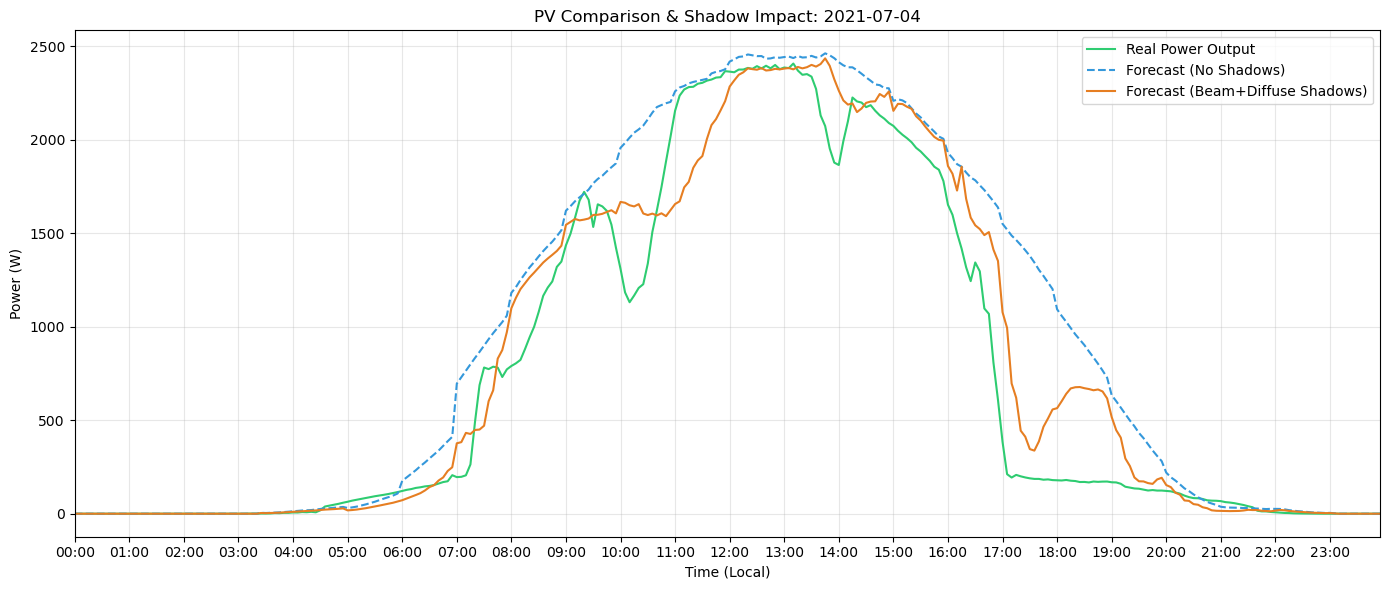

In [13]:
# %% --- 7. Single-Day Analysis (with plot) ---
day_data, forecast_base, forecast_windowed = pv_analysis(
    target_date=second_day,
    shadow_matrix=shadow_matrix,
    excel_df=pv_df,
    df_extra=extra_data_df,
    cfg=cfg,
    plot=True,
)